In [108]:
import numpy as np
import pandas as pd
from keras import models
from keras import layers
from keras import optimizers
from numpy.random import seed
import tensorflow

seed(1907)
tensorflow.random.set_seed(2)


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## FLOW:

In this study, by using the communities dataset, I'd like to build strong models to predict Per Capita Violent Crimes with a wide (but some of them similar !!!) feature set. After data cleaning and organization step, I will start with widely used ML algorithms, Support Vector Machine and finally Neural Network.

In [109]:
df = pd.read_csv('communities.csv')

In [110]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 127 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  1994 non-null   int64  
 1   county                 820 non-null    float64
 2   community              817 non-null    float64
 3   communityname          1994 non-null   object 
 4   population             1994 non-null   float64
 5   householdsize          1994 non-null   float64
 6   racepctblack           1994 non-null   float64
 7   racePctWhite           1994 non-null   float64
 8   racePctAsian           1994 non-null   float64
 9   racePctHisp            1994 non-null   float64
 10  agePct12t21            1994 non-null   float64
 11  agePct12t29            1994 non-null   float64
 12  agePct16t24            1994 non-null   float64
 13  agePct65up             1994 non-null   float64
 14  numbUrban              1994 non-null   float64
 15  pct

When data information is observed, there are 1994 inputs and except from the variable communityname which contain string values, all variables are either float or integer. Variable community name is a non-predictive variable given just for information along with variables state, county, community and fold. 

These variables, except of 'fold', contain significate number of null values and they should be dropped from the database. 

Additionally, another interesting observation is that variables contain either no null values or 319 non-null values which might indicate missing information for a mutual reason. These null values should be treated carefully not to lose required information or overpresent the same information in a way that would mislead the model. Also, dropping these variables is a valid option since a large portion of those variables are null.

Target: ViolentCrimesPerPop

Metric: RMSE

### Data Organization:

Aside from columns that contain null values, other variables do not require any type or dummy transformation. After handling null values, correlation among variables should be closely monitored.

Columns that contain null values are law enforcement and police related. I examined these variables one by one and most of them are numeric values but LemasGangUnitDeploy is actually ordinal. 

When I implement data imputation for these variables, I assume that these indicators might have a changing effect among regions but more similar within and depends on the population size as well. Therefore I am going to try assigning state medians for per population variables (not means since outliers for large states might affect the mean) to these columns of states that are null and null county values from its state. Nominal variable along with variables that are not per population ara going to be dropped.

In [111]:
# These variables are found to be relational with others (per population versions etc.) and are dropped. Others that contain
# null are assumed to be correlated (if county) with other counties within that state and median of counties is assigned. 

# If all inputs are null for a state, then median of states is assigned first. Then if a value is null median of counties of
# that specific state is going to be assined. But almost half of county values are null, for those, general median value is 
# going to be assigned.

to_be_dropped = ['LemasSwornFT',
                 'LemasSwFTFieldOps',
                 'LemasTotalReq',
                 'PolicReqPerOffic',
                 'PctPolicWhite',
                 'PctPolicBlack',
                 'PctPolicHisp',
                 'PctPolicAsian',
                 'OfficAssgnDrugUnits',
                 'NumKindsDrugsSeiz',
                 'PolicCars',
                 'LemasGangUnitDeploy',
                 'LemasPctOfficDrugUn',
                 'PolicOperBudg']

df1 = df.drop(to_be_dropped,axis=1)


In [112]:
def state_null_assignment(df,col):
    all_median = round(df[col].median(),2)
    for st in df.state.unique():
        state_median = df[df['state']==st][col].median()
        if df[df['state']==st][[col]].isna().values.all():
            df[col]= np.where((df[col].isna())&(df['state']==st),all_median, df[col])
        else:
            df[col]= np.where((df[col].isna())&(df['state']==st),state_median, df[col])
    return df

In [113]:
to_be_changed =  ['LemasSwFTPerPop',
                  'LemasSwFTFieldPerPop',
                  'LemasTotReqPerPop',
                  'PolicPerPop',
                  'RacialMatchCommPol',
                  'PctPolicMinor',
                  'PolicAveOTWorked',
                  'LemasPctPolicOnPatr',
                  'PolicBudgPerPop']

# Null variables dropped version is saved to be used for later
df2 = df1.drop(to_be_changed,axis=1)
for col in to_be_changed:
    df1 = state_null_assignment(df1,col)

In [114]:
df1.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 113 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  1994 non-null   int64  
 1   county                 820 non-null    float64
 2   community              817 non-null    float64
 3   communityname          1994 non-null   object 
 4   population             1994 non-null   float64
 5   householdsize          1994 non-null   float64
 6   racepctblack           1994 non-null   float64
 7   racePctWhite           1994 non-null   float64
 8   racePctAsian           1994 non-null   float64
 9   racePctHisp            1994 non-null   float64
 10  agePct12t21            1994 non-null   float64
 11  agePct12t29            1994 non-null   float64
 12  agePct16t24            1994 non-null   float64
 13  agePct65up             1994 non-null   float64
 14  numbUrban              1994 non-null   float64
 15  pct

In [115]:
df1.drop(['state','county','community','communityname',],inplace=True, axis=1)

#### Data imputation is done, but these variables are going to be closely monitored during feature selection. First, let's see correlation among variables:

As it can bee seen variables are not strongly correlated except from some groups which we know from variable explanations.

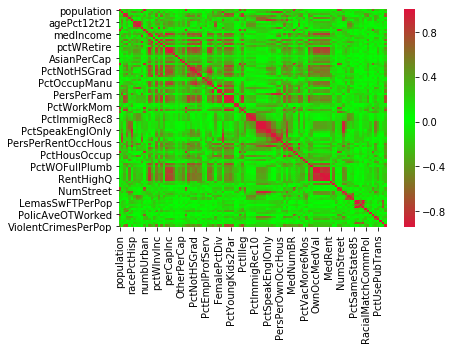

In [116]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'lime', 'crimson'])
corr = df1.corr()
sns.heatmap(corr, cmap=cmap)

In [117]:
pd.set_option('display.max_columns', 500)
df1.describe(include='all')

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumIlleg,PctIlleg,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwFTPerPop,LemasSwFTFieldPerPop,LemasTotReqPerPop,PolicPerPop,RacialMatchCommPol,PctPolicMinor,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,LemasPctPolicOnPatr,PolicBudgPerPop,ViolentCrimesPerPop
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1993.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,0.424218,0.493867,0.336264,0.423164,0.064072,0.696269,0.361123,0.558154,0.291570,0.495687,0.471133,0.317778,0.479248,0.375677,0.350251,0.368049,0.291098,0.203506,0.322357,0.284742,0.386279,0.055507,0.303024,0.315807,0.383330,0.361675,0.363531,0.501073,0.396384,0.440597,0.391224,0.441339,0.461244,0.434453,0.487568,0.494273,0.487748,0.610918,0.620657,0.664032,0.582884,0.501449,0.526690,0.036294,0.249995,0.030060,0.320211,0.360622,0.399077,0.427879,0.181364,0.182126,0.184774,0.182879,0.785903,0.150587,0.267608,0.251891,0.462101,0.494428,0.404097,0.562598,0.186264,0.495186,0.314694,0.076815,0.719549,0.548686,0.204529,0.433335,0.494178,0.264478,0.243059,0.264689,0.263490,0.268942,0.346379,0.372457,0.422964,0.384102,0.490125,0.449754,0.403816,0.029438,0.022778,0.215552,0.608892,0.535050,0.626424,0.651530,0.187816,0.223684,0.176108,0.187821,0.704521,0.219656,0.263621,0.065231,0.232854,0.161685,0.726610,0.164942,0.237979
std,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,0.155196,0.143564,0.166505,0.179185,0.128256,0.444811,0.209362,0.182913,0.204108,0.178071,0.173619,0.222137,0.167564,0.198257,0.191109,0.186804,0.171593,0.

In [118]:
# One value was empty for this column :)

df1['OtherPerCap'].fillna(0,inplace=True)
df1.to_pickle('final_data.pkl')

X = df1.copy().drop('ViolentCrimesPerPop',axis=1)
y = df1['ViolentCrimesPerPop']

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state=42)

### Really basic decision tree and random forest regressors:

In [12]:
clf = DecisionTreeRegressor(criterion = 'mse')

clf = clf.fit(train_x, train_y)
y_pred1 = clf.predict(test_x)

print('RMSE: ',mean_squared_error(test_y, y_pred1))

RMSE:  0.04023547094188377


In [13]:
rfc = RandomForestRegressor(n_estimators=100, max_features=10)

rfc = rfc.fit(train_x, train_y)
y_pred1 = rfc.predict(test_x)

print('RMSE: ',mean_squared_error(test_y, y_pred1))

RMSE:  0.017011882805611226


### SVM Trial:

In [14]:
from sklearn import svm

svcf = svm.LinearSVR()
svcf.fit(train_x,train_y)
y_pred = svcf.predict(test_x)


print("RMSE: ", mean_squared_error(test_y, y_pred))

RMSE:  0.017679354102171963


C:\Users\okana\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### NN Trials: 

Here, I will try different NN Models with different optimizers, activation functions, layers etc. Whilst trying those, firstly, higher batch size and  lower number of epochs are chosen to save time. Later on, with the final model, epoch and batch size will be optimized as well. In the last case, the model will be tried with the dataset without the variables that went thorough imputation (df2).

#### Since we are working with regression for a target variable between 0-1, either mse or binary_crossentropy is most useful as the loss function. Initially, I am going to work with mse, but the final model will be tested with binary_crossentropy as well.

#### Also, for the reason specified above, sigmoid is going to be utilized as the last layer activation function for this problem. 

#### Aside from these, different optimizers with various hyperparameters, number of layers and neurons and activation functions are going to be tried. Initially, I have chosen Adams as the optimizer based on my previous experiences.

In [15]:
def nn_model(network, num_epoch, size):
    
    network.fit(train_x, train_y, epochs = num_epoch, batch_size = size)
    nn_pred = network.predict(test_x)

    print ("RMSE:", mean_squared_error(test_y, nn_pred))    
    
    return mean_squared_error(test_y, nn_pred)

In [16]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(250,  activation='selu'))
network.add(layers.Dense(150, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 20, 20)

Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0428 - mse: 0.0428
Epoch 2/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0219 - mse: 0.0219
Epoch 3/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0202 - mse: 0.0202
Epoch 4/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0193 - mse: 0.0193
Epoch 5/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0189 - mse: 0.0189
Epoch 6/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0182 - mse: 0.0182
Epoch 7/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0181 - mse: 0.0181
Epoch 8/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0179 - mse: 0.0179
Epoch 9/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0180 - mse: 0.0180
Epoch 10/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0174 - mse: 0.0174
Epoch 11/20
75/75 [==============================] - 0s 1ms/step - lo

0.016640675706989592

#### Lets try with additional layers and different number of neurons:

In [21]:
# Best performing so far:

network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 20, 20)

Epoch 1/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0356
Epoch 2/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0224 - mse: 0.0224
Epoch 3/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0208 - mse: 0.0208
Epoch 4/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0197 - mse: 0.0197
Epoch 5/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0191 - mse: 0.0191
Epoch 6/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0184 - mse: 0.0184
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0181 - mse: 0.0181
Epoch 8/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0179 - mse: 0.0179
Epoch 9/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0181 - mse: 0.0181
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0173 - mse: 0.0173
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - lo

0.015958158512176007

In [23]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(125,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 20, 20)

Epoch 1/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0314 - mse: 0.0314
Epoch 2/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0209 - mse: 0.0209
Epoch 3/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0197 - mse: 0.0197
Epoch 4/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0188 - mse: 0.0188
Epoch 5/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0181 - mse: 0.0181
Epoch 6/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0174 - mse: 0.0174
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0174 - mse: 0.0174
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0173 - mse: 0.0173
Epoch 9/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0175 - mse: 0.0175
Epoch 10/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0167 - mse: 0.0167
Epoch 11/20
75/75 [==============================] - 0s 1ms/step - lo

0.016718961617348437

In [32]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(100,  activation='selu'))
network.add(layers.Dense(25, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 20, 20)

Epoch 1/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0475 - mse: 0.0475
Epoch 2/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0217 - mse: 0.0217
Epoch 3/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0200 - mse: 0.0200
Epoch 4/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0193 - mse: 0.0193
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0186 - mse: 0.0186
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0183 - mse: 0.0183
Epoch 7/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0181 - mse: 0.0181
Epoch 8/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0180 - mse: 0.0180
Epoch 9/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0182 - mse: 0.0182
Epoch 10/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0174 - mse: 0.0174
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - lo

0.017282542511783086

#### Let's try another optimizer: Adagrad

In [45]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adagrad(learning_rate=0.01, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 20, 20)

Epoch 1/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0376 - mse: 0.0376
Epoch 2/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0227 - mse: 0.0227
Epoch 3/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0214 - mse: 0.0214
Epoch 4/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0205 - mse: 0.0205
Epoch 5/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0202 - mse: 0.0202
Epoch 6/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0203 - mse: 0.0203
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0194 - mse: 0.0194
Epoch 8/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0195 - mse: 0.0195
Epoch 9/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0191 - mse: 0.0191
Epoch 10/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0188 - mse: 0.0188
Epoch 11/20
75/75 [==============================] - 0s 1ms/step - lo

0.01866751153956107

In [48]:
# With different learning rate:

network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adagrad(learning_rate=0.001, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 50, 20)

Epoch 1/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0444 - mse: 0.0444
Epoch 2/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0330 - mse: 0.0330
Epoch 3/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0283 - mse: 0.0283
Epoch 4/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0257 - mse: 0.0257
Epoch 5/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0242 - mse: 0.0242
Epoch 6/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0232 - mse: 0.0232
Epoch 7/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0224 - mse: 0.0224
Epoch 8/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0220 - mse: 0.0220
Epoch 9/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0215 - mse: 0.0215
Epoch 10/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0213 - mse: 0.0213
Epoch 11/50
75/75 [==============================] - 0s 1ms/step - lo

0.017657592242014374

#### It did not show significant improvement: lets try Adadelta

In [49]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adadelta(learning_rate=0.001, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 50, 20)

Epoch 1/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0919 - mse: 0.0919
Epoch 2/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0852 - mse: 0.0852
Epoch 3/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0771 - mse: 0.0771
Epoch 4/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0697 - mse: 0.0697
Epoch 5/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0643 - mse: 0.0643
Epoch 6/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0606 - mse: 0.0606
Epoch 7/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0576 - mse: 0.0576
Epoch 8/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0550 - mse: 0.0550
Epoch 9/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0527 - mse: 0.0527
Epoch 10/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0505 - mse: 0.0505
Epoch 11/50
75/75 [==============================] - 0s 1ms/step - lo

0.020208779323656438

In [51]:
# With different learning rate:

network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adadelta(learning_rate=0.01, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 50, 20)

Epoch 1/50
75/75 [==============================] - 0s 1ms/step - loss: 0.1388 - mse: 0.1388
Epoch 2/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0430 - mse: 0.0430
Epoch 3/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0333 - mse: 0.0333
Epoch 4/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0277 - mse: 0.0277
Epoch 5/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0248 - mse: 0.0248
Epoch 6/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0232 - mse: 0.0232
Epoch 7/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0222 - mse: 0.0222
Epoch 8/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0218 - mse: 0.0218
Epoch 9/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0213 - mse: 0.0213
Epoch 10/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0211 - mse: 0.0211
Epoch 11/50
75/75 [==============================] - 0s 1ms/step - lo

0.017397551778631296

In [54]:
# With different learning rate:

network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adadelta(learning_rate=0.1, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 100, 10)

Epoch 1/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0274 - mse: 0.0274
Epoch 2/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0211 - mse: 0.0211
Epoch 3/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0208 - mse: 0.0208
Epoch 4/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0193 - mse: 0.0193
Epoch 5/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0192 - mse: 0.0192
Epoch 6/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0188 - mse: 0.0188
Epoch 7/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0189 - mse: 0.0189
Epoch 8/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0186 - mse: 0.0186
Epoch 9/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0178 - mse: 0.0178
Epoch 10/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0181 - mse: 0.0181
Epoch 11/100
150/150 [=================

0.017340958127609322

#### Even with greater number of epochs and smaller batch size, no improvement with Adadelta as well, lets try RMSprop:

In [55]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.RMSprop(learning_rate=0.1, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 100, 10)

Epoch 1/100
150/150 [==============================] - 0s 1ms/step - loss: 0.1162 - mse: 0.1162
Epoch 2/100
150/150 [==============================] - 0s 1ms/step - loss: 0.1157 - mse: 0.1157
Epoch 3/100
150/150 [==============================] - 0s 1ms/step - loss: 0.1157 - mse: 0.1157
Epoch 4/100
150/150 [==============================] - 0s 1ms/step - loss: 0.1157 - mse: 0.1157
Epoch 5/100
150/150 [==============================] - 0s 2ms/step - loss: 0.1157 - mse: 0.1157
Epoch 6/100
150/150 [==============================] - 0s 2ms/step - loss: 0.1157 - mse: 0.1157
Epoch 7/100
150/150 [==============================] - 0s 1ms/step - loss: 0.1157 - mse: 0.1157
Epoch 8/100
150/150 [==============================] - 0s 1ms/step - loss: 0.1157 - mse: 0.1157
Epoch 9/100
150/150 [==============================] - 0s 1ms/step - loss: 0.1157 - mse: 0.1157
Epoch 10/100
150/150 [==============================] - 0s 1ms/step - loss: 0.1157 - mse: 0.1157
Epoch 11/100
150/150 [=================

0.09644408817635272

In [59]:
# Different learning rate:

network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.RMSprop(learning_rate=0.00001, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 100, 10)

Epoch 1/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0762 - mse: 0.0762
Epoch 2/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0321 - mse: 0.0321
Epoch 3/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0256 - mse: 0.0256
Epoch 4/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0231 - mse: 0.0231
Epoch 5/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0218 - mse: 0.0218
Epoch 6/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0211 - mse: 0.0211
Epoch 7/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0205 - mse: 0.0205
Epoch 8/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0203 - mse: 0.0203
Epoch 9/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0198 - mse: 0.0198
Epoch 10/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0197 - mse: 0.0197
Epoch 11/100
150/150 [=================

0.016328408481651194

#### Similar results with Adams, lets try different neuron structure:

In [60]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(125,  activation='selu'))
network.add(layers.Dense(100,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.RMSprop(learning_rate=0.00001, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 100, 10)

Epoch 1/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0937 - mse: 0.0937
Epoch 2/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0339 - mse: 0.0339
Epoch 3/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0275 - mse: 0.0275
Epoch 4/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0244 - mse: 0.0244
Epoch 5/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0227 - mse: 0.0227
Epoch 6/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0217 - mse: 0.0217A: 0s - loss: 0.0215 - mse: 0.021
Epoch 7/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0211 - mse: 0.0211
Epoch 8/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0208 - mse: 0.0208
Epoch 9/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0203 - mse: 0.0203
Epoch 10/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0200 - mse: 0.0200
Epoch 

0.016726743468810167

In [61]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.RMSprop(learning_rate=0.00001, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 100, 10)

Epoch 1/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0714 - mse: 0.0714
Epoch 2/100
150/150 [==============================] - 0s 984us/step - loss: 0.0302 - mse: 0.0302
Epoch 3/100
150/150 [==============================] - 0s 965us/step - loss: 0.0258 - mse: 0.0258
Epoch 4/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0235 - mse: 0.0235
Epoch 5/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0222 - mse: 0.0222
Epoch 6/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0215 - mse: 0.0215
Epoch 7/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0208 - mse: 0.0208
Epoch 8/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0206 - mse: 0.0206
Epoch 9/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0203 - mse: 0.0203
Epoch 10/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0201 - mse: 0.0201
Epoch 11/100
150/150 [=============

0.01634610235988587

In [62]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(250,  activation='selu'))
network.add(layers.Dense(100, activation='selu'))
network.add(layers.Dense(50, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.RMSprop(learning_rate=0.00001, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 100, 10)

Epoch 1/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0918 - mse: 0.0918
Epoch 2/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0416 - mse: 0.0416
Epoch 3/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0293 - mse: 0.0293
Epoch 4/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0246 - mse: 0.0246
Epoch 5/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0226 - mse: 0.0226
Epoch 6/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0217 - mse: 0.0217
Epoch 7/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0210 - mse: 0.0210
Epoch 8/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0207 - mse: 0.0207
Epoch 9/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0202 - mse: 0.0202
Epoch 10/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0200 - mse: 0.0200
Epoch 11/100
150/150 [=================

0.01635172009513418

In [63]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(125,  activation='selu'))
network.add(layers.Dense(100, activation='selu'))
network.add(layers.Dense(50, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.RMSprop(learning_rate=0.00001, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 100, 10)

Epoch 1/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0510 - mse: 0.0510
Epoch 2/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0330 - mse: 0.0330
Epoch 3/100
150/150 [==============================] - 0s 985us/step - loss: 0.0280 - mse: 0.0280
Epoch 4/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0256 - mse: 0.0256
Epoch 5/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0242 - mse: 0.0242
Epoch 6/100
150/150 [==============================] - 0s 991us/step - loss: 0.0234 - mse: 0.0234
Epoch 7/100
150/150 [==============================] - 0s 993us/step - loss: 0.0225 - mse: 0.0225
Epoch 8/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0220 - mse: 0.0220
Epoch 9/100
150/150 [==============================] - 0s 993us/step - loss: 0.0215 - mse: 0.0215
Epoch 10/100
150/150 [==============================] - 0s 986us/step - loss: 0.0211 - mse: 0.0211
Epoch 11/100
150/150 [=======

0.01587084918627268

In [64]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(100,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(50, activation='selu'))
network.add(layers.Dense(25, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.RMSprop(learning_rate=0.00001, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 100, 10)

Epoch 1/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0978 - mse: 0.0978
Epoch 2/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0426 - mse: 0.0426
Epoch 3/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0299 - mse: 0.0299
Epoch 4/100
150/150 [==============================] - 0s 991us/step - loss: 0.0258 - mse: 0.0258
Epoch 5/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0239 - mse: 0.0239
Epoch 6/100
150/150 [==============================] - 0s 986us/step - loss: 0.0227 - mse: 0.0227
Epoch 7/100
150/150 [==============================] - 0s 979us/step - loss: 0.0218 - mse: 0.0218
Epoch 8/100
150/150 [==============================] - 0s 987us/step - loss: 0.0214 - mse: 0.0214
Epoch 9/100
150/150 [==============================] - 0s 985us/step - loss: 0.0208 - mse: 0.0208
Epoch 10/100
150/150 [==============================] - 0s 964us/step - loss: 0.0205 - mse: 0.0205
Epoch 11/100
150/150 [=====

0.0160947792598437

#### Overall it does not beat Adams significantly even with greater epoch and smaller batch size, lets try SGD:

In [65]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(100,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(50, activation='selu'))
network.add(layers.Dense(25, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.SGD(learning_rate=0.00001)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 100, 10)

Epoch 1/100
150/150 [==============================] - 0s 959us/step - loss: 0.0977 - mse: 0.0977
Epoch 2/100
150/150 [==============================] - 0s 975us/step - loss: 0.0917 - mse: 0.0917
Epoch 3/100
150/150 [==============================] - 0s 957us/step - loss: 0.0867 - mse: 0.0867
Epoch 4/100
150/150 [==============================] - 0s 944us/step - loss: 0.0824 - mse: 0.0824
Epoch 5/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0788 - mse: 0.0788
Epoch 6/100
150/150 [==============================] - 0s 925us/step - loss: 0.0757 - mse: 0.0757
Epoch 7/100
150/150 [==============================] - 0s 977us/step - loss: 0.0731 - mse: 0.0731
Epoch 8/100
150/150 [==============================] - 0s 911us/step - loss: 0.0707 - mse: 0.0707
Epoch 9/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0688 - mse: 0.0688
Epoch 10/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0670 - mse: 0.0670
Epoch 11/100
150/150 [===

0.038206462411096896

In [70]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.SGD(learning_rate=0.001)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 100, 5)

Epoch 1/100
299/299 [==============================] - 0s 977us/step - loss: 0.0478 - mse: 0.0478
Epoch 2/100
299/299 [==============================] - 0s 1ms/step - loss: 0.0318 - mse: 0.0318
Epoch 3/100
299/299 [==============================] - 0s 957us/step - loss: 0.0281 - mse: 0.0281
Epoch 4/100
299/299 [==============================] - 0s 954us/step - loss: 0.0260 - mse: 0.0260
Epoch 5/100
299/299 [==============================] - 0s 922us/step - loss: 0.0247 - mse: 0.0247
Epoch 6/100
299/299 [==============================] - 0s 945us/step - loss: 0.0237 - mse: 0.0237
Epoch 7/100
299/299 [==============================] - 0s 941us/step - loss: 0.0230 - mse: 0.0230
Epoch 8/100
299/299 [==============================] - 0s 957us/step - loss: 0.0227 - mse: 0.0227 0s - loss: 0.0228 - mse: 0
Epoch 9/100
299/299 [==============================] - 0s 983us/step - loss: 0.0222 - mse: 0.0222
Epoch 10/100
299/299 [==============================] - 0s 964us/step - loss: 0.0220 - mse: 0

0.016331999287428133

#### So far, no optimizer has beaten Adams, lets continue with that and try adjustments on it:

In [ ]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(150,  activation='selu'))
network.add(layers.Dense(75, activation='selu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 20, 20)

In [83]:
# relu seems better:

network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(75, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 20, 20)

Epoch 1/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0530 - mse: 0.0530
Epoch 2/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0298 - mse: 0.0298
Epoch 3/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0225 - mse: 0.0225
Epoch 4/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0201 - mse: 0.0201
Epoch 5/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0192 - mse: 0.0192
Epoch 6/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0185 - mse: 0.0185
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0182 - mse: 0.0182
Epoch 8/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0179 - mse: 0.0179
Epoch 9/20
75/75 [==============================] - 0s 1ms/step - loss: 0.0175 - mse: 0.0175
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0172 - mse: 0.0172
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - lo

0.01571275705272471

#### Data is small, so lets try no batch by setting batch size=1:

In [89]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(75, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 20, 1)

Epoch 1/20
1495/1495 [==============================] - 1s 935us/step - loss: 0.0280 - mse: 0.0280
Epoch 2/20
1495/1495 [==============================] - 1s 805us/step - loss: 0.0198 - mse: 0.0198
Epoch 3/20
1495/1495 [==============================] - 1s 826us/step - loss: 0.0192 - mse: 0.0192
Epoch 4/20
1495/1495 [==============================] - 1s 811us/step - loss: 0.0182 - mse: 0.0182
Epoch 5/20
1495/1495 [==============================] - 1s 811us/step - loss: 0.0176 - mse: 0.0176
Epoch 6/20
1495/1495 [==============================] - 1s 810us/step - loss: 0.0171 - mse: 0.0171
Epoch 7/20
1495/1495 [==============================] - 1s 813us/step - loss: 0.0167 - mse: 0.0167
Epoch 8/20
1495/1495 [==============================] - 1s 818us/step - loss: 0.0162 - mse: 0.0162
Epoch 9/20
1495/1495 [==============================] - 1s 825us/step - loss: 0.0154 - mse: 0.0154
Epoch 10/20
1495/1495 [==============================] - 1s 815us/step - loss: 0.0154 - mse: 0.0154 1s - lo
E

0.01724397219578467

### Not 1 but 5:

In [90]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(75, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 20, 5)

Epoch 1/20
299/299 [==============================] - 0s 1ms/step - loss: 0.0379 - mse: 0.0379
Epoch 2/20
299/299 [==============================] - 0s 1ms/step - loss: 0.0208 - mse: 0.0208
Epoch 3/20
299/299 [==============================] - 0s 1ms/step - loss: 0.0192 - mse: 0.0192
Epoch 4/20
299/299 [==============================] - 0s 1ms/step - loss: 0.0185 - mse: 0.0185
Epoch 5/20
299/299 [==============================] - 0s 989us/step - loss: 0.0180 - mse: 0.0180
Epoch 6/20
299/299 [==============================] - 0s 1ms/step - loss: 0.0174 - mse: 0.0174
Epoch 7/20
299/299 [==============================] - 0s 1ms/step - loss: 0.0169 - mse: 0.0169
Epoch 8/20
299/299 [==============================] - 0s 1ms/step - loss: 0.0171 - mse: 0.0171
Epoch 9/20
299/299 [==============================] - 0s 1ms/step - loss: 0.0162 - mse: 0.0162
Epoch 10/20
299/299 [==============================] - 0s 992us/step - loss: 0.0160 - mse: 0.0160
Epoch 11/20
299/299 [========================

0.016092324143828135

#### Batch Size 10

In [91]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(75, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 20, 10)

Epoch 1/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0481 - mse: 0.0481
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0214 - mse: 0.0214
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0192 - mse: 0.0192
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0185 - mse: 0.0185
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0180 - mse: 0.0180
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0175 - mse: 0.0175
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0171 - mse: 0.0171
Epoch 8/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0170 - mse: 0.0170
Epoch 9/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0167 - mse: 0.0167
Epoch 10/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0163 - mse: 0.0163
Epoch 11/20
150/150 [============================

0.015499581180733244

#### Lets increase layers:

In [93]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(125,  activation='relu'))
network.add(layers.Dense(100,  activation='relu'))
network.add(layers.Dense(100,  activation='relu'))
network.add(layers.Dense(75,  activation='relu'))
network.add(layers.Dense(75,  activation='relu'))
network.add(layers.Dense(50, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 20, 10)

Epoch 1/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0575 - mse: 0.0575
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0241 - mse: 0.0241
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0206 - mse: 0.0206
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0193 - mse: 0.0193
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0184 - mse: 0.0184
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0176 - mse: 0.0176
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0171 - mse: 0.0171
Epoch 8/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0167 - mse: 0.0167
Epoch 9/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0162 - mse: 0.0162
Epoch 10/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0159 - mse: 0.0159
Epoch 11/20
150/150 [============================

0.01812546147669597

In [94]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(125,  activation='relu'))
network.add(layers.Dense(75,  activation='relu'))
network.add(layers.Dense(50, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 20, 10)

Epoch 1/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0605 - mse: 0.0605
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0260 - mse: 0.0260
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0212 - mse: 0.0212
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0198 - mse: 0.0198
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0188 - mse: 0.0188A: 0s - loss: 0.0193 - mse: 0.0
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0180 - mse: 0.0180
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0175 - mse: 0.0175
Epoch 8/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0175 - mse: 0.0175
Epoch 9/20
150/150 [==============================] - 0s 1ms/step - loss: 0.0169 - mse: 0.0169
Epoch 10/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0166 - mse: 0.0166
Epoch 11/20
150/15

0.016404804890947904

#### Initial layers & neurons were optimal, lets try that with greater number of epochs:

In [95]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(75, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 200, 10)

Epoch 1/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0547 - mse: 0.0547
Epoch 2/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0226 - mse: 0.0226
Epoch 3/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0198 - mse: 0.0198
Epoch 4/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0190 - mse: 0.0190
Epoch 5/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0185 - mse: 0.0185A: 0s - loss: 0.0195 - mse: 0.01
Epoch 6/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0180 - mse: 0.0180
Epoch 7/200
150/150 [==============================] - 0s 2ms/step - loss: 0.0176 - mse: 0.0176
Epoch 8/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0176 - mse: 0.0176
Epoch 9/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0173 - mse: 0.0173
Epoch 10/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0170 - mse: 0.0170
Epoch 1

150/150 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016 
Epoch 168/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012 
Epoch 169/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0011 - mse: 0.0011
Epoch 170/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012 
Epoch 171/200
150/150 [==============================] - 0s 1ms/step - loss: 9.8855e-04 - mse: 9.8855e-04
Epoch 172/200
150/150 [==============================] - 0s 1000us/step - loss: 9.6184e-04 - mse: 9.6184e-04
Epoch 173/200
150/150 [==============================] - 0s 998us/step - loss: 9.8754e-04 - mse: 9.8754e-04
Epoch 174/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012
Epoch 175/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0013 - mse: 0.0013
Epoch 176/200
150/150 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014 
E

0.022905188271791672

In [97]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(75, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 50, 10)

Epoch 1/50
150/150 [==============================] - 0s 1ms/step - loss: 0.0505 - mse: 0.0505
Epoch 2/50
150/150 [==============================] - 0s 1ms/step - loss: 0.0231 - mse: 0.0231
Epoch 3/50
150/150 [==============================] - 0s 1ms/step - loss: 0.0201 - mse: 0.0201
Epoch 4/50
150/150 [==============================] - 0s 1ms/step - loss: 0.0191 - mse: 0.0191
Epoch 5/50
150/150 [==============================] - 0s 2ms/step - loss: 0.0185 - mse: 0.0185
Epoch 6/50
150/150 [==============================] - 0s 1ms/step - loss: 0.0179 - mse: 0.0179
Epoch 7/50
150/150 [==============================] - 0s 1ms/step - loss: 0.0175 - mse: 0.0175
Epoch 8/50
150/150 [==============================] - 0s 1ms/step - loss: 0.0173 - mse: 0.0173
Epoch 9/50
150/150 [==============================] - 0s 2ms/step - loss: 0.0169 - mse: 0.0169
Epoch 10/50
150/150 [==============================] - 0s 1ms/step - loss: 0.0166 - mse: 0.0166
Epoch 11/50
150/150 [============================

0.017720541239983442

In [99]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(75, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 100, 20)

Epoch 1/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0647 - mse: 0.0647
Epoch 2/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0306 - mse: 0.0306
Epoch 3/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0217 - mse: 0.0217
Epoch 4/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0200 - mse: 0.0200
Epoch 5/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0195 - mse: 0.0195
Epoch 6/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0188 - mse: 0.0188
Epoch 7/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0186 - mse: 0.0186
Epoch 8/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0182 - mse: 0.0182
Epoch 9/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0179 - mse: 0.0179
Epoch 10/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0174 - mse: 0.0174
Epoch 11/100
75/75 [==============================] - 0s 1m

0.01965443633053583

### Final Model:

In [126]:
network = models.Sequential()
network.add(layers.Dense(108, input_dim=108, activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(150,  activation='relu'))
network.add(layers.Dense(125,  activation='relu'))
network.add(layers.Dense(75,  activation='relu'))
network.add(layers.Dense(50, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)
network.compile(optimizer=opt,
loss='mse',
metrics=['mse'])

nn_model(network, 10, 25)

Epoch 1/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0727 - mse: 0.0727
Epoch 2/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0345 - mse: 0.0345
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0232 - mse: 0.0232
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0207 - mse: 0.0207
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0199 - mse: 0.0199
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0191 - mse: 0.0191
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0188 - mse: 0.0188
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0183 - mse: 0.0183
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0180 - mse: 0.0180
Epoch 10/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0176 - mse: 0.0176
RMSE: 0.01588039837255645


0.01588039837255645